In [1]:
import numpy as np
import pandas as pd
import time

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from pathlib import Path

#for dirname, _, filenames in os.walk('/kaggle/input'):
for dirname, _, filenames in os.walk("input"):
    print(dirname)

input
input\evaluation
input\training


In [2]:
#data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
data_path = Path('input/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'
training_tasks = sorted(os.listdir(training_path))
eval_tasks = sorted(os.listdir(evaluation_path))

In [3]:
#已解決的ID
solved_id=set()
solved_eva_id=set()

In [4]:
T = training_tasks
Trains = []
for i in range(400):
    task_file = str(training_path / T[i])
    task = json.load(open(task_file, 'r'))
    Trains.append(task)
    
E = eval_tasks
Evals= []
for i in range(400):
    task_file = str(evaluation_path / E[i])
    task = json.load(open(task_file, 'r'))
    Evals.append(task)

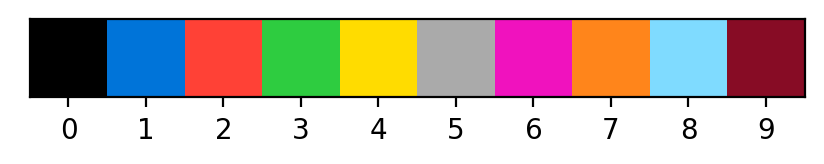

In [5]:
cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)
# 0:black, 1:blue, 2:red, 3:greed, 4:yellow,
# 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
plt.figure(figsize=(5, 2), dpi=200)
plt.imshow([list(range(10))], cmap=cmap, norm=norm)
plt.xticks(list(range(10)))
plt.yticks([])
plt.show()

def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()

In [6]:

def plot_picture(x):
    plt.imshow(np.array(x), cmap = cmap, norm = norm)
    plt.show()

In [7]:
def Defensive_Copy(A): 
    if type(A)!=list:
        A=A.tolist()
    n = len(A)
    k = len(A[0])
    L = np.zeros((n,k), dtype = int)
    for i in range(n):
        for j in range(k):
            L[i,j] = 0 + A[i][j]
    return L.tolist()

In [8]:
def Create(task, task_id = 0):
    n = len(task['train'])
    Input = [Defensive_Copy(task['train'][i]['input']) for i in range(n)]
    Output = [Defensive_Copy(task['train'][i]['output']) for i in range(n)]
    Input.append(Defensive_Copy(task['test'][task_id]['input']))
    return Input, Output

In [9]:
BACKGROUND=0
def _get_bound(img0):
    img=np.array(img0)
    h, w = img.shape
    x0 = w - 1
    x1 = 0
    y0 = h - 1
    y1 = 0
    for x in range(w):
        for y in range(h):
            if img[y, x] == BACKGROUND:
                continue
            x0 = min(x0, x)
            x1 = max(x1, x)
            y0 = min(y0, y)
            y1 = max(y1, y)
    return x0, x1, y0, y1
def get_bound_image(img0):
    x0,x1,y0,y1=_get_bound(img0)
    img=np.array(img0)
    return img[y0:y1+1,x0:x1+1].tolist()
BACKGROUND = 0

_neighbor_offsets = {
    4: [(1, 0), (-1, 0), (0, 1), (0, -1)],
    8: [(1, 0), (-1, 0), (0, 1), (0, -1), (-1, -1), (-1, 1), (1, -1), (1, 1)]
}
def _expand_region_indices(img, i, j, neighbor=4):
    h, w = img.shape
    seed_color = img[i, j]
    idx = np.zeros_like(img, dtype=np.bool)
    region = []
    region.append((i, j))
    while len(region) > 0:
        ii, jj = region.pop()
        if img[ii, jj] != seed_color:
            continue
        idx[ii, jj] = True
        for di, dj in _neighbor_offsets[neighbor]:
            ni, nj = ii + di, jj + dj
            if ni >= 0 and ni < h and nj >= 0 and nj < w \
                    and not idx[ni, nj]:
                region.append((ni, nj))
    return idx
def _expand_region_indices01(img, i, j, neighbor=4):
    h, w = img.shape
    seed_color = 1
    idx = np.zeros_like(img, dtype=np.bool)
    region = []
    region.append((i, j))
    while len(region) > 0:
        ii, jj = region.pop()
        if img[ii, jj] == 0:
            continue
        idx[ii, jj] = True
        for di, dj in _neighbor_offsets[neighbor]:
            ni, nj = ii + di, jj + dj
            if ni >= 0 and ni < h and nj >= 0 and nj < w \
                    and not idx[ni, nj]:
                region.append((ni, nj))
    return idx
def _split_conn(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices(img, i, j, neighbor)
            mem[conn_idx] = True
            regions.append((np.where(conn_idx, img, BACKGROUND)).tolist())
    return regions
def _split_conn01(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices01(img, i, j, neighbor)
            mem[conn_idx] = True
            regions.append((np.where(conn_idx, img, BACKGROUND)).tolist())
    return regions
def split_conn(img): 
    ''' Split an image into a list of images each containing a single connected region'''
    
    return _split_conn(img, 4)
def split_conn8(img):
    ''' Split an image into a list of images each containing a single connected region.
      Pixels of 8 neighbors are all considered "connected"
    '''
    
    return _split_conn(img, 8)

def split_conn01(img): 
    ''' Split an image into a list of images each containing a single connected region'''
    
    return _split_conn01(img, 4)
def split_conn801(img):
    ''' Split an image into a list of images each containing a single connected region.
      Pixels of 8 neighbors are all considered "connected"
    '''
    
    return _split_conn01(img, 8)

def _split_object(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices(img, i, j, neighbor)
            mem[conn_idx] = True
            splitimage=np.where(conn_idx, img, BACKGROUND)
#             minx=0
#             miny=0
#             maxx=0
#             maxy=0
#             for m in range(h):
#                 if sum(splitimage[m,:])!=0:
#                     miny=m
#                     break
#             for n in range(w):
#                 if sum(splitimage[:,n])!=0:
#                     minx=n
#                     break
#             for m in range(h-1,-1,-1):
#                 if sum(splitimage[m,:])!=0:
#                     maxy=m
#                     break
#             for n in range(w-1,-1,-1):
#                 if sum(splitimage[:,n])!=0:
#                     maxx=n
#                     break
            (minx,maxx,miny,maxy)=_get_bound(splitimage)
            split_object=(splitimage[miny:maxy+1,minx:maxx+1]).tolist()
            
            
            regions.append({'start': (miny, minx), 'obj':split_object})
    return regions

def _split_object01(img0, neighbor=4):
    regions = []
    img=np.array(img0)
    mem = np.zeros_like(img, dtype=np.bool)
    h, w = img.shape
    for j in range(w):
        for i in range(h):
            p = img[i, j]
            if p == BACKGROUND or mem[i, j]:
                continue
            conn_idx = _expand_region_indices01(img, i, j, neighbor)
            mem[conn_idx] = True
            splitimage=np.where(conn_idx, img, BACKGROUND)
#             minx=0
#             miny=0
#             maxx=0
#             maxy=0
#             for m in range(h):
#                 if sum(splitimage[m,:])!=0:
#                     miny=m
#                     break
#             for n in range(w):
#                 if sum(splitimage[:,n])!=0:
#                     minx=n
#                     break
#             for m in range(h-1,-1,-1):
#                 if sum(splitimage[m,:])!=0:
#                     maxy=m 
#                     break
#             for n in range(w-1,-1,-1):
#                 if sum(splitimage[:,n])!=0:
#                     maxx=n
#                     break
        
            (minx,maxx,miny,maxy)=_get_bound(splitimage)
            split_object=(splitimage[miny:maxy+1,minx:maxx+1]).tolist()
            
            
            regions.append({'start': (miny, minx), 'obj':split_object})
    return regions
def split_color(img0): 
    
    img=np.array(img0)
    color = np.unique(img)
    return [np.where(img == c, c, 0) for c in color if c != BACKGROUND]
def split_color_crop(img0): 
    color_image=[]
    img=np.array(img0)
    color = np.unique(img)
    for c in color:
        if c!=BACKGROUND:
            imgc=np.where(img == c, c, 0)
            x0, x1, y0, y1=_get_bound(imgc)
            imgc=(imgc[y0:y1+1,x0:x1+1]).tolist()
            color_image.append(imgc)
    
    
    return color_image
def split_object(img):
    return _split_object(img, neighbor=4)
def split_object8(img):
    return _split_object(img, neighbor=8)
def split_object01(img):
    return _split_object01(img, neighbor=4)
def split_object801(img):
    return _split_object01(img, neighbor=8)


In [10]:
def object_dict(d):
    name_dic={}
    obj_dic={}
    for i in range(len(d)):
        d_obj=d[i]["obj"]
        if str(d_obj) not in name_dic:
            name_dic[str(d_obj)]=d_obj
            obj_dic[str(d_obj)]=1
        else:
            obj_dic[str(d_obj)]+=1
    
    return obj_dic,name_dic

In [11]:
def getObjectHash(pixmap):
    flat = pixmap.flatten().astype(np.bool)
    mult = np.array([2 ** x for x in range(len(flat))])
    return np.sum(flat * mult)
#經測試沒有overflow問題
def groupByColor(pixmap):
    nb_colors = int(pixmap.max()) + 1
    splited = [(pixmap == i) * i for i in range(1, nb_colors)]
    return [x for x in splited if np.any(x)]
def checkColorMap(a0,b0):
    a=np.array(a0)
    b=np.array(b0)
    c = 1
    inp_hashes = sorted([getObjectHash(pm) for pm in groupByColor(a)])
    out_hashes = sorted([getObjectHash(pm) for pm in groupByColor(b)])
    c *= inp_hashes == out_hashes
    return bool(c)
def findColorMap(a,b):
    colormap = {}
    a1=np.array(a).flatten()
    b1=np.array(b).flatten()

    for col, idx in zip(*np.unique(a1,return_index=True)):
        if col in colormap.keys(): continue
        colormap[col] = b1[idx]
    return colormap
def applyColorMap(pixmap, colormap):
    a1=np.array(pixmap)
    for i in range(a1.shape[0]):
        for j in range(a1.shape[1]):
            if a1[i][j] not in colormap: #
                continue #
            a1[i][j]=colormap[pixmap[i][j]]
    return a1.tolist()

In [12]:
a=Trains[219]["train"][0]["input"]

In [13]:
split_object801(a)[0]["obj"]

[[3]]

In [14]:
# #dic(array)
# #plit_object801
# def inoutmap3(basic_task):
#     Input = [Defensive_Copy(x) for x in basic_task[0]]
#     Output = [Defensive_Copy(y) for y in basic_task[1]]
#     Test_Case = Input[-1]
#     Input = Input[:-1]
#     name_dic={}
#     obj_dic={}
#     for x, y in zip(Input,Output):
#         x_array=np.array(x)
#         y_array=np.array(y)
#         n0,m0=len(x),len(x[0])
#         a=split_object801(x)
#         if len(a)>10 or len(a)==0:
#             return -1
#         obj=[]
#         for i in range(len(a)):
#             obj.append(a[i]["obj"])
#         di_obj=[]
#         for i in range(len(obj)):
#             if obj[i] not in di_obj:
#                 di_obj.append(obj[i])

#         for k in range(len(di_obj)):
#             example=di_obj[k]
#             #print(example)
#             n,m=len(example),len(example[0])
#             for i in range(n0-n+1):
#                 for j in range(m0-m+1):
#                     if x_array[i:i+n,j:j+m].tolist()==example:
                        
#                         if i-1>=0 and i+n+1<=n0 and j-1>=0 and j+m+1<=m0:
                            
#                             tmp_x=x_array[i-1:i+n+1,j-1:j+m+1]
#                             tmp_y=y_array[i-1:i+n+1,j-1:j+m+1]
#                             if str(tmp_x) not in obj_dic:
#                                 name_dic[str(tmp_x)]=tmp_x
#                                 obj_dic[str(tmp_x)]=tmp_y
#         #print(obj_dic)

#     return name_dic,obj_dic
    
    

In [15]:
# #dic(array)
# #plit_object801
# def inoutmap0(basic_task):
#     Input = [Defensive_Copy(x) for x in basic_task[0]]
#     Output = [Defensive_Copy(y) for y in basic_task[1]]
#     Test_Case = Input[-1]
#     Input = Input[:-1]
#     name_dic={}
#     obj_dic={}
#     for x, y in zip(Input,Output):
#         x_array=np.array(x)
#         y_array=np.array(y)
#         n0,m0=len(x),len(x[0])
#         a=split_object801(x)
#         if len(a)>10 or len(a)==0:
#             return -1
#         obj=[]
#         for i in range(len(a)):
#             obj.append(a[i]["obj"])
#         di_obj=[]
#         for i in range(len(obj)):
#             if obj[i] not in di_obj:
#                 di_obj.append(obj[i])
#         #print(di_obj)

#         for k in range(len(di_obj)):
#             example=di_obj[k]
           
#             n,m=len(example),len(example[0])
            
#             for i in range(n0-n+1):
#                 for j in range(m0-m+1):
                    
#                     if x_array[i:i+n,j:j+m].tolist()==example:
                        
                        
#                         if i>=0 and i+n<=n0 and j>=0 and j+m<=m0:
                            
#                             tmp_x=x_array[i:i+n,j:j+m]
#                             tmp_y=y_array[i:i+n,j:j+m]
#                             if str(tmp_x) not in obj_dic:
#                                 name_dic[str(tmp_x)]=tmp_x
#                                 obj_dic[str(tmp_x)]=tmp_y
#         #print(obj_dic)

#     return name_dic,obj_dic
    

In [16]:
#dic(array)
#plit_object801
def inoutmap(basic_task,n1,n2,m1,m2):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    name_dic={}
    obj_dic={}
    for x, y in zip(Input,Output):
        x_array=np.array(x)
        y_array=np.array(y)
        n0,m0=len(x),len(x[0])
        a=split_object801(x)
        if len(a)>10 or len(a)==0:
            return -1
        obj=[]
        for i in range(len(a)):
            obj.append(a[i]["obj"])
        di_obj=[]
        for i in range(len(obj)):
            if obj[i] not in di_obj:
                di_obj.append(obj[i])
        



        for k in range(len(di_obj)):
            example=di_obj[k]
            #print(example)
            n,m=len(example),len(example[0])
            for i in range(n0-n+1):
                for j in range(m0-m+1):
                    if x_array[i:i+n,j:j+m].tolist()==example:
                        
                        if i-n1>=0 and i+n+n2<=n0 and j-m1>=0 and j+m+m2<=m0:
                            
                            tmp_x=x_array[i-n1:i+n+n2,j-m1:j+m+m2]
                            tmp_y=y_array[i-n1:i+n+n2,j-m1:j+m+m2]
                            if str(tmp_x) not in obj_dic:
                                name_dic[str(tmp_x)]=tmp_x
                                obj_dic[str(tmp_x)]=tmp_y
        #print(obj_dic)

    return name_dic,obj_dic

In [17]:
# def solve_inoutmap3(basic_task):
#     Input = [Defensive_Copy(x) for x in basic_task[0]]
#     Output = [Defensive_Copy(y) for y in basic_task[1]]
#     Test_Case = Input[-1]
#     Input = Input[:-1]
    
#     if inoutmap3(basic_task)==-1:
#         return -1
#     name_dic,object_dict=inoutmap(basic_task,1,1,1,1)
    
#     for x, y in zip(Input,Output):
        
#         if len(x)!=len(y) or len(x[0])!=len(y[0]):
#             return -1
#         x_array=np.array(x)
#         x_array_pad=np.pad(x_array,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#         x_array_copy=x_array.copy()
#         x_pad1=np.pad(x_array_copy,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#         y_array=np.array(y)
#         n0,m0=len(x),len(x[0])
        
#         a=split_object801(x)
        
#         if len(a)>10 or len(a)==0:
#             return -1
#         obj=[]
#         for i in range(len(a)):
#             obj.append(a[i]["obj"])
#         di_obj=[]
#         for i in range(len(obj)):
#             if obj[i] not in di_obj:
#                 di_obj.append(obj[i])
#         #print(di_obj)
#         for k in range(len(di_obj)):
#             example=di_obj[k]
#             n,m=len(example),len(example[0])
#             for i in range(n0-n+1):
#                 for j in range(m0-m+1):
#                     if x_array_pad[i+1:i+n+1,j+1:j+m+1].tolist()==example:
                        
#                         if str(x_array_pad[i:i+n+1+1,j:j+m+1+1]) not in object_dict:
#                             return -1
                       

#                         try:
#                             x_pad1[i:i+n+1+1,j:j+m+1+1]=object_dict[str(x_array_pad[i:i+n+1+1,j:j+m+1+1])]
                            
#                         except:
#                             return-1
                        
#         #avoid x_pad1[0:0,0:0]
#         #print(x_pad1)
#         x_pad2=np.pad(x_pad1,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#         #print(x_pad2)
#         res=x_pad2[2:-2,2:-2]
#         #print(res)
        
#         if not (res==y_array).all():
#             return -1
        
    
#     Test_Case_array=np.array(Test_Case)
#     Test_Case_array_copy=Test_Case_array.copy()
#     Test_Case_pad=np.pad(Test_Case_array_copy,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#     Test_Case_pad1=np.pad(Test_Case_array_copy,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#     n0,m0=len(Test_Case),len(Test_Case[0])
#     a=split_object801(Test_Case)
#     obj=[]
    
#     for i in range(len(a)):
#         obj.append(a[i]["obj"])
#     di_obj=[]
#     for i in range(len(obj)):
#         if obj[i] not in di_obj:
#             di_obj.append(obj[i])
#     for k in range(len(di_obj)):
#             example=di_obj[k]
#             n,m=len(example),len(example[0])
#             for i in range(n0-n+1):
#                 for j in range(m0-m+1):
#                     if  Test_Case_pad[i+1:i+n+1,j+1:j+m+1].tolist()==example:
                        
#                         if str(Test_Case_pad[i:i+n+1+1,j:j+m+1+1]) not in object_dict:
#                             return -1
                        
                       
#                         Test_Case_pad1[i:i+n+1+1,j:j+m+1+1]=object_dict[str(Test_Case_pad[i:i+n+1+1,j:j+m+1+1])]
#                         Test_Case_pad2=np.pad(Test_Case_pad1,((1,1),(1,1)),'constant',constant_values = (0,0))
#     return Test_Case_pad2[2:-2,2:-2].tolist()

In [29]:
def solve_inoutmap(basic_task,n1,n2,m1,m2):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    
    if inoutmap(basic_task,n1,n2,m1,m2)==-1:
        return -1
    name_dic,object_dict=inoutmap(basic_task,n1,n2,m1,m2)
    
    for x, y in zip(Input,Output):
        
        if len(x)!=len(y) or len(x[0])!=len(y[0]):
            return -1
        x_array=np.array(x)
        x_array_pad=np.pad(x_array,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
        x_array_copy=x_array.copy()
        x_pad1=np.pad(x_array_copy,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
        y_array=np.array(y)
        n0,m0=len(x),len(x[0])
        
        a=split_object801(x)
        
        if len(a)>10 or len(a)==0:
            return -1
        obj=[]
        for i in range(len(a)):
            obj.append(a[i]["obj"])
        di_obj=[]
        for i in range(len(obj)):
            if obj[i] not in di_obj:
                di_obj.append(obj[i])
        #print(di_obj)
        for k in range(len(di_obj)):
            example=di_obj[k]
            n,m=len(example),len(example[0])
            for i in range(n0-n+1):
                for j in range(m0-m+1):
                    if x_array_pad[i+n1:i+n+n1,j+m1:j+m+m1].tolist()==example:
                        
                        if str(x_array_pad[i:i+n+n1+n2,j:j+m+m1+m2]) not in object_dict:
                            return -1
                       

                        try:
                            x_pad1[i:i+n+n1+n2,j:j+m+m1+m2]=object_dict[str(x_array_pad[i:i+n+n1+n2,j:j+m+m1+m2])]
                            
                        except:
                            return-1
                        
        #avoid x_pad1[0:0,0:0]
        #print(x_pad1)
        x_pad2=np.pad(x_pad1,((1,1),(1,1)),'constant',constant_values = (0,0)) 
        #print(x_pad2)
        res=x_pad2[1+n1:-1-n2,1+m1:-1-m2]
        #print(res)
        
        if not (res==y_array).all():
            return -1
        
    
    Test_Case_array=np.array(Test_Case)
    Test_Case_array_copy=Test_Case_array.copy()
    Test_Case_pad=np.pad(Test_Case_array_copy,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
    Test_Case_pad1=np.pad(Test_Case_array_copy,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
    n0,m0=len(Test_Case),len(Test_Case[0])
    a=split_object801(Test_Case)
    obj=[]
    
    for i in range(len(a)):
        obj.append(a[i]["obj"])
    di_obj=[]
    for i in range(len(obj)):
        if obj[i] not in di_obj:
            di_obj.append(obj[i])
    for k in range(len(di_obj)):
            example=di_obj[k]
            n,m=len(example),len(example[0])
            for i in range(n0-n+1):
                for j in range(m0-m+1):
                    if  Test_Case_pad[i+n1:i+n+n1,j+m1:j+m+m1].tolist()==example:
                        
                        if str(Test_Case_pad[i:i+n+n1+n2,j:j+m+m1+m2]) not in object_dict:
                            return -1
                        
                       
                        Test_Case_pad1[i:i+n+n1+n2,j:j+m+m1+m2]=object_dict[str(Test_Case_pad[i:i+n+n1+n2,j:j+m+m1+m2])]
                        Test_Case_pad2=np.pad(Test_Case_pad1,((1,1),(1,1)),'constant',constant_values = (0,0))
    return Test_Case_pad2[1+n1:-1-n2,1+m1:-1-m2].tolist()

In [30]:
#dont use solve_inoutmap_colormap(basic_task,0,0,0,0)
#use solve_inoutmap(basic_task,0,0,0,0)
def solve_inoutmap_colormap(basic_task,n1,n2,m1,m2):
    Input = [Defensive_Copy(x) for x in basic_task[0]]
    Output = [Defensive_Copy(y) for y in basic_task[1]]
    Test_Case = Input[-1]
    Input = Input[:-1]
    
    if inoutmap(basic_task,n1,n2,m1,m2)==-1:
        return -1
    name_dic,object_dict=inoutmap(basic_task,n1,n2,m1,m2)
    
    for x, y in zip(Input,Output):
        
        if len(x)!=len(y) or len(x[0])!=len(y[0]):
            return -1
        x_array=np.array(x)
        x_array_pad=np.pad(x_array,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
        #print(x_array_pad)
        x_array_copy=x_array.copy()
        x_pad1=np.pad(x_array_copy,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
        y_array=np.array(y)
        n0,m0=len(x),len(x[0])
        
        a=split_object801(x)
        
        if len(a)>10 or len(a)==0:
            return -1
        obj=[]
        for i in range(len(a)):
            obj.append(a[i]["obj"])
        di_obj=[]
        for i in range(len(obj)):
            if obj[i] not in di_obj:
                di_obj.append(obj[i])
        #print(di_obj)
        for k in range(len(di_obj)):
            example=di_obj[k]
            n,m=len(example),len(example[0])
            for i in range(n0-n+1):
                for j in range(m0-m+1):
                    if x_array_pad[i+n1:i+n+n1,j+m1:j+m+m1].tolist()==example:
                        
                        if str(x_array_pad[i:i+n+n1+n2,j:j+m+m1+m2]) not in object_dict:
                            return -1
                       

                        try:
                            x_pad1[i:i+n+n1+n2,j:j+m+m1+m2]=object_dict[str(x_array_pad[i:i+n+n1+n2,j:j+m+m1+m2])]
                            
                        except:
                            return-1
                        
        #avoid x_pad1[0:0,0:0]
        #print(x_pad1)
        x_pad2=np.pad(x_pad1,((1,1),(1,1)),'constant',constant_values = (0,0)) 
 
        #print(x_pad2)
        res=x_pad2[1+n1:-1-n2,1+m1:-1-m2]
    
        #print(res)
        
        if not (res==y_array).all():
            return -1
        
    
    Test_Case_array=np.array(Test_Case)
    Test_Case_array_copy=Test_Case_array.copy()
    Test_Case_pad=np.pad(Test_Case_array_copy,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
    Test_Case_pad1=np.pad(Test_Case_array_copy,((n1,n2),(m1,m2)),'constant',constant_values = (0,0)) 
    n0,m0=len(Test_Case),len(Test_Case[0])
    a=split_object801(Test_Case)
    obj=[]
    
    for i in range(len(a)):
        obj.append(a[i]["obj"])
    di_obj=[]
    for i in range(len(obj)):
        if obj[i] not in di_obj:
            di_obj.append(obj[i])
    for k in range(len(di_obj)):
            example=di_obj[k]
            n,m=len(example),len(example[0])
            for i in range(n0-n+1):
                for j in range(m0-m+1):
                    if  Test_Case_pad[i+n1:i+n+n1,j+m1:j+m+m1].tolist()==example:
                        
                        if str(Test_Case_pad[i:i+n+n1+n2,j:j+m+m1+m2]) in object_dict:
                            Test_Case_pad1[i:i+n+n1+n2,j:j+m+m1+m2]=object_dict[str(Test_Case_pad[i:i+n+n1+n2,j:j+m+m1+m2])]
                        else:
                            color_res=False
                            for value in name_dic.values():
                                if checkColorMap(Test_Case_pad[i:i+n+n1+n2,j:j+m+m1+m2],value)==True and value.shape!=(n1+1+n2,m1+1+m2):
                                    colormap=findColorMap(value,Test_Case_pad[i:i+n+n1+n2,j:j+m+m1+m2])
                                    Test_Case_pad1[i:i+n+n1+n2,j:j+m+m1+m2]=np.array(applyColorMap(object_dict[str(value)],colormap))
                                    color_res=True
                                    break
                            if color_res==False:
                                return -1
                        
                       
                        
                        Test_Case_pad2=np.pad(Test_Case_pad1,((1,1),(1,1)),'constant',constant_values = (0,0))
    return Test_Case_pad2[1+n1:-1-n2,1+m1:-1-m2].tolist()

In [31]:
# for i in range(98,99):
#     task = Trains[i]
#     k = len(task['test'])

#     for j in range(k):        
#         basic_task = Create(task, j)
#         a=solve_inoutmap_colormap(basic_task,1,0,0,0)
#         if a!=-1 :
#             print(i,j)
#             #solved_train.append((i,j))
#             plot_task(task)
#             plot_picture(a)
#             solved_id.add(i)
        
# # has problem

In [32]:
# for i in range(400):
#     task = Trains[i]
#     k = len(task['test'])

#     for j in range(k):        
#         basic_task = Create(task, j)
#         a=solve_inoutmap_colormap(basic_task,2,2,2,2)
#         if a!=-1 :
#             print(i,j)
#             #solved_train.append((i,j))
#             plot_task(task)
#             plot_picture(a)
#             solved_id.add(i)
 
            

In [33]:
# def solve_inoutmap0(basic_task):
#     Input = [Defensive_Copy(x) for x in basic_task[0]]
#     Output = [Defensive_Copy(y) for y in basic_task[1]]
#     Test_Case = Input[-1]
#     Input = Input[:-1]
    
#     if inoutmap3(basic_task)==-1:
#         return -1
#     name_dic,object_dict=inoutmap(basic_task,0,0,0,0)
#     #print(object_dict)
    
#     for x, y in zip(Input,Output):
        
#         if len(x)!=len(y) or len(x[0])!=len(y[0]):
#             return -1
#         x_array=np.array(x)
#         x_array_pad=np.pad(x_array,((0,0),(0,0)),'constant',constant_values = (0,0)) 
#         x_array_copy=x_array.copy()
#         x_pad1=np.pad(x_array_copy,((0,0),(0,0)),'constant',constant_values = (0,0)) 
#         y_array=np.array(y)
#         n0,m0=len(x),len(x[0])
        
#         a=split_object801(x)
        
#         if len(a)>10 or len(a)==0:
#             return -1
#         obj=[]
#         for i in range(len(a)):
#             obj.append(a[i]["obj"])
#         di_obj=[]
#         for i in range(len(obj)):
#             if obj[i] not in di_obj:
#                 di_obj.append(obj[i])
#         #print(di_obj)
#         for k in range(len(di_obj)):
#             example=di_obj[k]
#             n,m=len(example),len(example[0])
#             for i in range(n0-n+1):
#                 for j in range(m0-m+1):
#                     if x_array_pad[i:i+n,j:j+m].tolist()==example:
                        
#                         if str(x_array_pad[i:i+n,j:j+m]) not in object_dict:
#                             return -1
                       

#                         try:
#                             x_pad1[i:i+n,j:j+m]=object_dict[str(x_array_pad[i:i+n,j:j+m])]
                            
#                         except:
#                             return-1
#         #avoid x_pad1[0:0,0:0]
#         x_pad2=np.pad(x_pad1,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#         res=x_pad2[1:-1,1:-1]
#         #print(res)
       
        
#         if not (res==y_array).all():
#             return -1
        
    
#     Test_Case_array=np.array(Test_Case)
#     Test_Case_array_copy=Test_Case_array.copy()
#     Test_Case_pad=np.pad(Test_Case_array_copy,((0,0),(0,0)),'constant',constant_values = (0,0)) 
#     Test_Case_pad1=np.pad(Test_Case_array_copy,((0,0),(0,0)),'constant',constant_values = (0,0)) 
#     n0,m0=len(Test_Case),len(Test_Case[0])
#     a=split_object801(Test_Case)
#     obj=[]
    
#     for i in range(len(a)):
#         obj.append(a[i]["obj"])
#     di_obj=[]
#     for i in range(len(obj)):
#         if obj[i] not in di_obj:
#             di_obj.append(obj[i])
#     for k in range(len(di_obj)):
#             example=di_obj[k]
#             n,m=len(example),len(example[0])
#             for i in range(n0-n+1):
#                 for j in range(m0-m+1):
#                     if  Test_Case_pad[i:i+n,j:j+m].tolist()==example:
                        
#                         if str(Test_Case_pad[i:i+n,j:j+m]) not in object_dict:
#                             return -1
                        
                       
#                         Test_Case_pad1[i:i+n,j:j+m]=object_dict[str(Test_Case_pad[i:i+n,j:j+m])]
#                         Test_Case_pad2=np.pad(Test_Case_pad1,((1,1),(1,1)),'constant',constant_values = (0,0)) 
#     return Test_Case_pad2[1:-1,1:-1].tolist()

In [34]:
# task=Trains[265]
# basic_task = Create(task, 0)
# # if solve_inoutmap3(basic_task)!=-1:
# #     plot_picture(solve_inoutmap3(basic_task))
# print(solve_inoutmap3(basic_task))

In [35]:
# for i in range(400):
#     task = Trains[i]
#     k = len(task['test'])

#     for j in range(k):        
#         basic_task = Create(task, j)
#         a=solve_inoutmap(basic_task,0,0,0,0)
#         if a!=-1 :
#             print(i,j)
#             #solved_train.append((i,j))
#             plot_task(task)
#             plot_picture(a)
#             solved_id.add(i)

In [36]:
# for i in range(400):
#     task = Evals[i]
#     k = len(task['test'])

#     for j in range(k):        
#         basic_task = Create(task, j)
#         a=solve_inoutmap(basic_task,0,0,0,0)
#         if a!=-1 :
#             print(i,j)
#             #solved_train.append((i,j))
#             plot_task(task)
#             plot_picture(a)
#             solved_eva_id.add(i)

In [37]:
# for i in range(400):
#     task = Trains[i]
#     k = len(task['test'])

#     for j in range(k):        
#         basic_task = Create(task, j)
#         a=solve_inoutmap(basic_task,1,1,1,1)
#         if a!=-1 :
#             print(i,j)
#             #solved_train.append((i,j))
#             plot_task(task)
#             plot_picture(a)
#             solved_id.add(i)

11 0


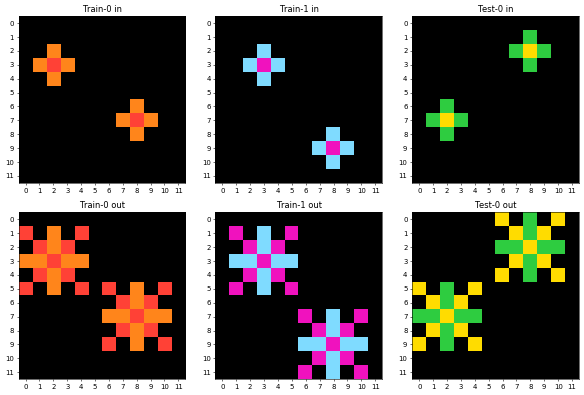

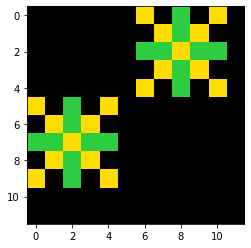

85 0


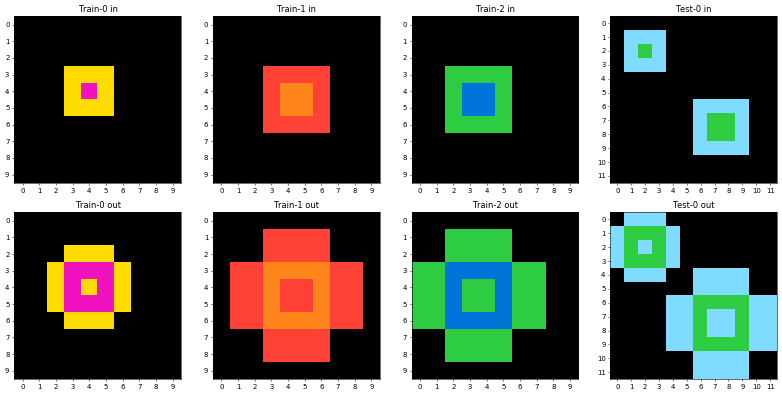

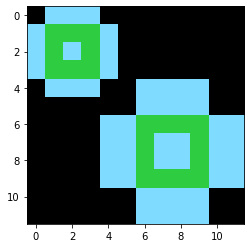

94 0


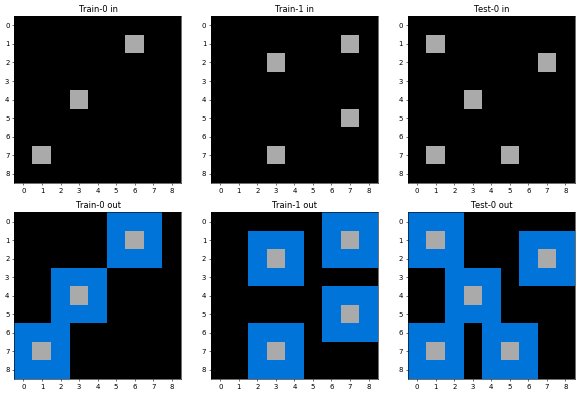

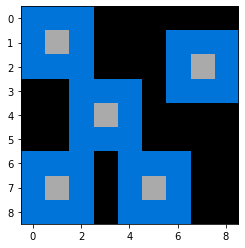

219 0


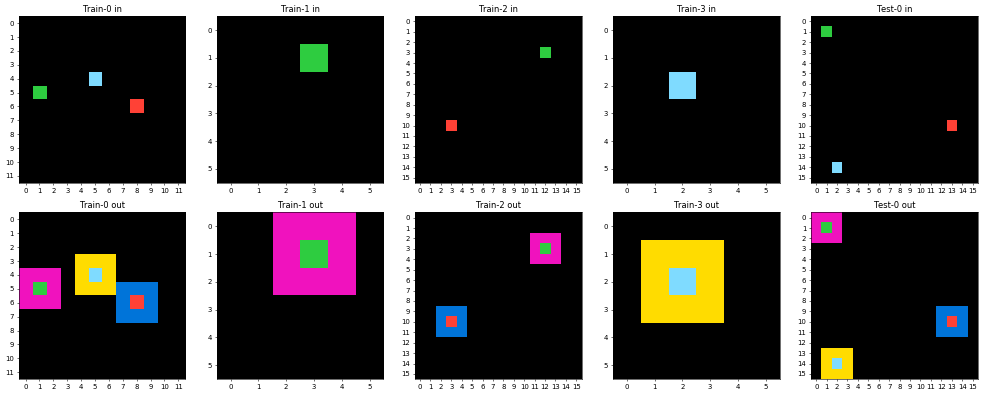

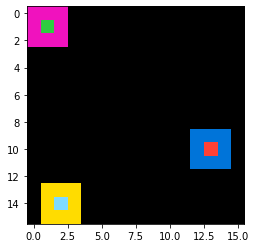

227 0


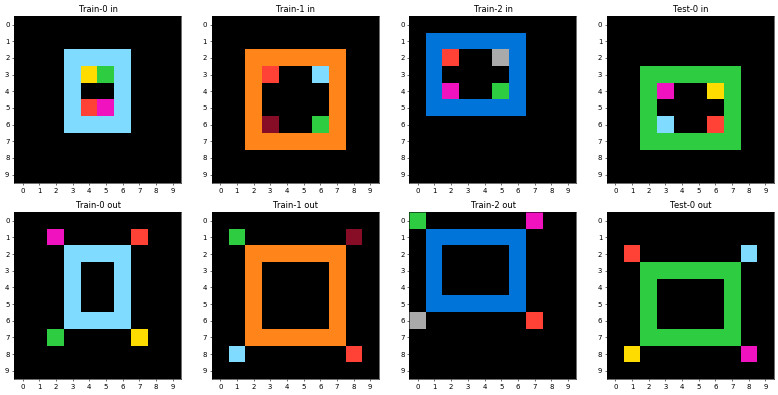

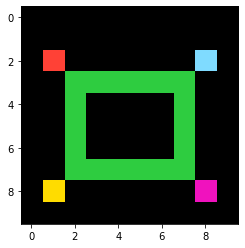

229 0


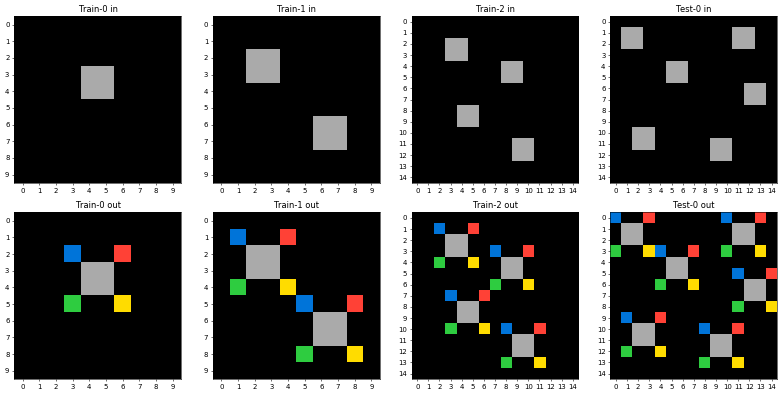

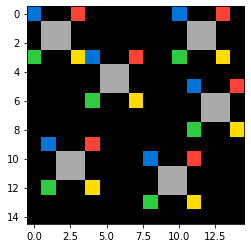

265 0


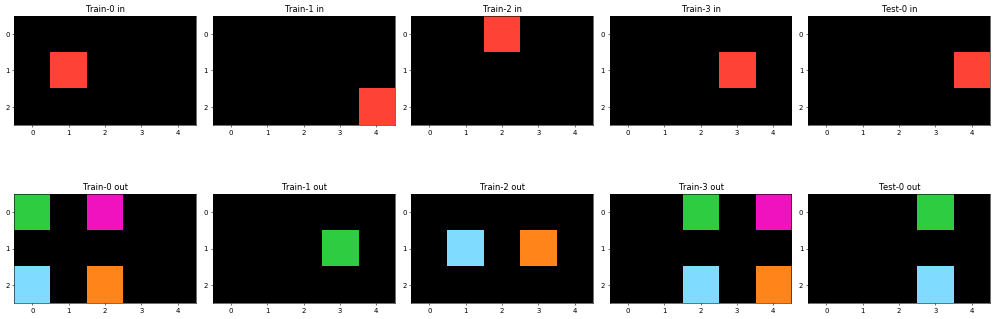

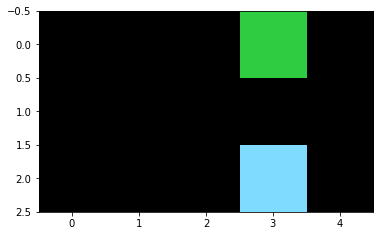

281 0


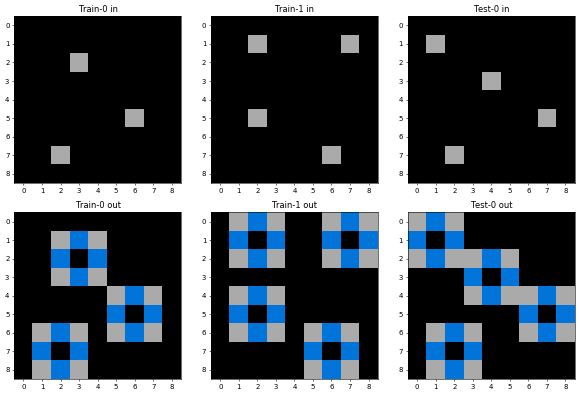

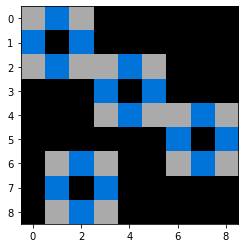

301 0


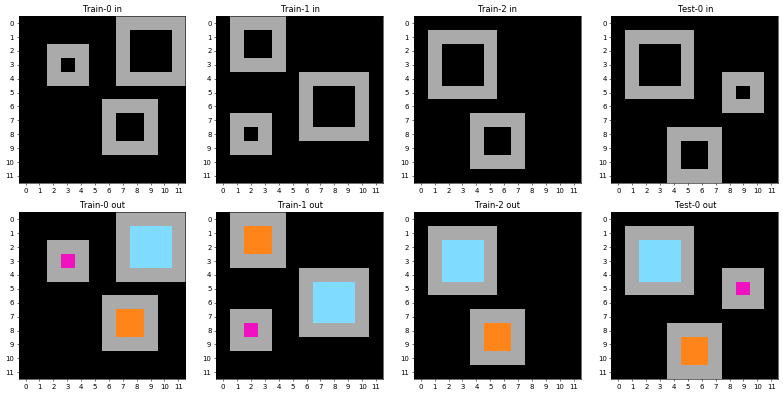

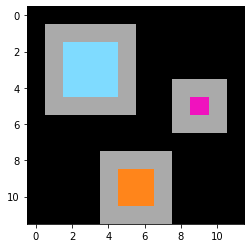

316 0


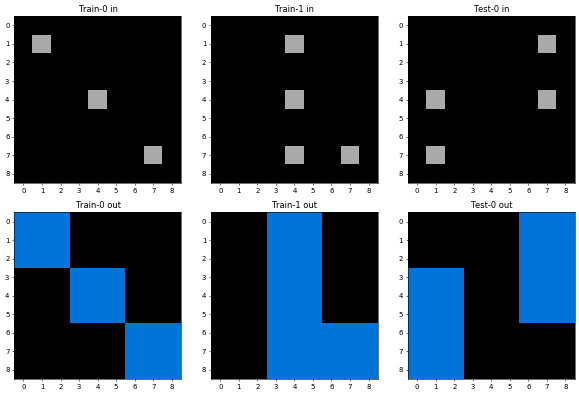

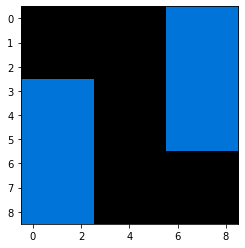

330 0


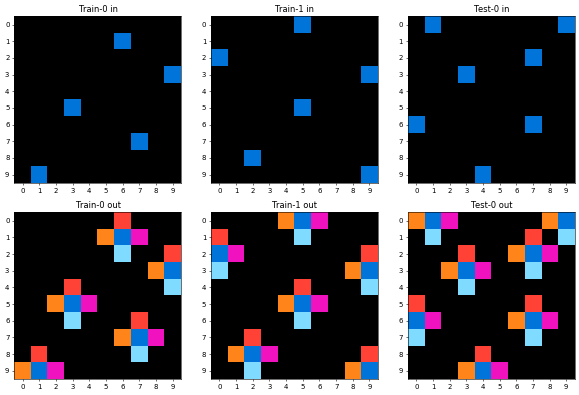

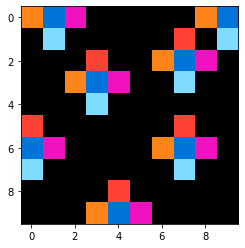

In [38]:
for i in range(400):
    task = Trains[i]
    k = len(task['test'])

    for j in range(k):        
        basic_task = Create(task, j)
        a=solve_inoutmap(basic_task,0,0,0,0)
        b=solve_inoutmap_colormap(basic_task,1,1,1,1)
        c=solve_inoutmap_colormap(basic_task,2,2,2,2)
        if a!=-1 or b!=-1 or c!=-1:
            print(i,j)
            #solved_train.append((i,j))
            plot_task(task)
            if a!=-1:
                plot_picture(a)
            elif b!=-1:
                plot_picture(b)
            elif c!=-1:
                plot_picture(c)
            solved_id.add(i)

156 0


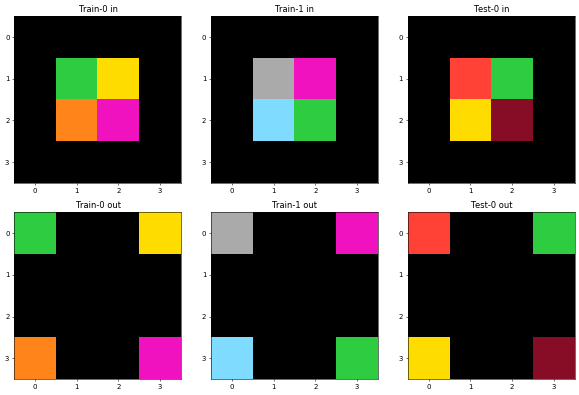

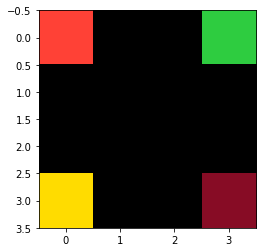

199 0


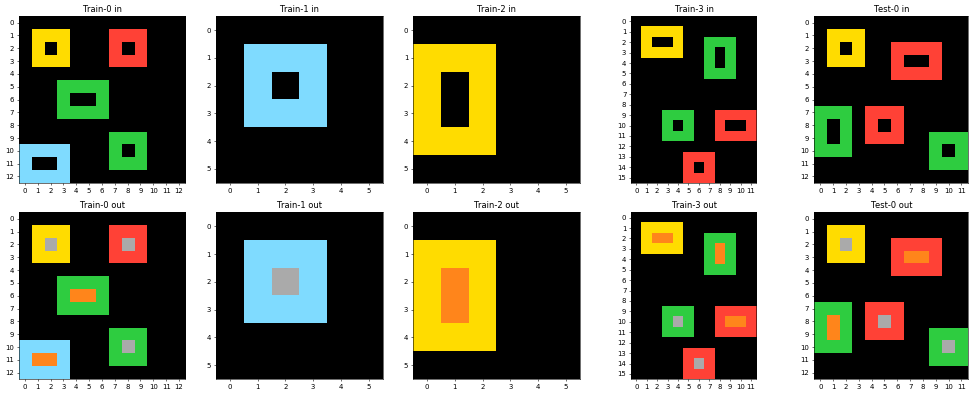

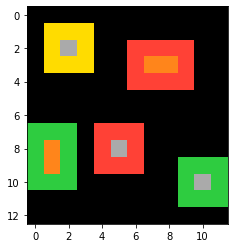

In [39]:
for i in range(400):
    task = Evals[i]
    k = len(task['test'])

    for j in range(k):        
        basic_task = Create(task, j)
        a=solve_inoutmap(basic_task,0,0,0,0)
        b=solve_inoutmap_colormap(basic_task,1,1,1,1)
        c=solve_inoutmap_colormap(basic_task,2,2,2,2)
        if a!=-1 or b!=-1 or c!=-1:
            print(i,j)
            #solved_train.append((i,j))
            plot_task(task)
            if a!=-1:
                plot_picture(a)
            elif b!=-1:
                plot_picture(b)
            elif c!=-1:
                plot_picture(c)
            solved_eva_id.add(i)

In [40]:
# Trains[229]["train"][0]["output"]

In [41]:
# a=Trains[0]["train"][0]["input"]
# b=Trains[229]["train"][0]["output"]
# np.array(a)[5:15,5:15]

# np.pad(a,((0,0),(0,0)),'constant',constant_values = (0,0)) 


In [42]:
list(solved_id)

[227, 229, 265, 330, 11, 301, 85, 281, 219, 316, 94]

In [43]:
list(solved_eva_id)

[156, 199]